<a href="https://colab.research.google.com/github/radharavinuthala/Restaurant-ratings-prediction-/blob/main/ML_internship_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mean Squared Error: 0.0849275452769684
R-squared: 0.25323441058726726
Mean Absolute Error: 0.2357069769119768


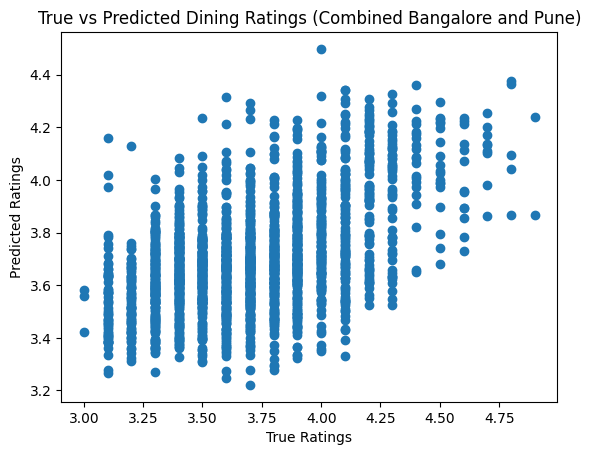

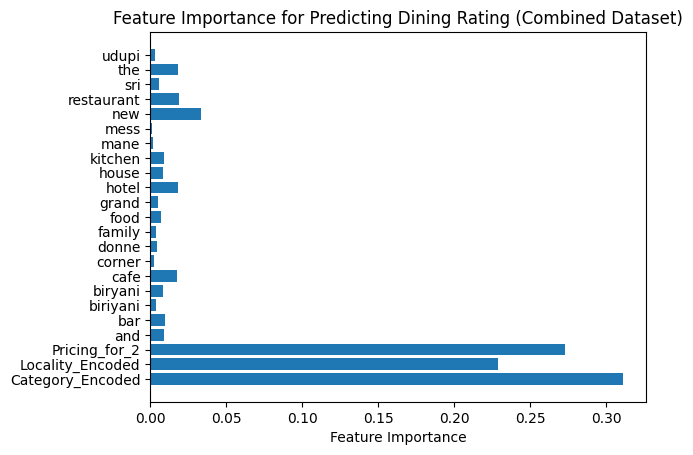

Cross-Validation MSE Scores: [-0.27370669 -0.28426958 -0.34496824]
Mean CV MSE: -0.3009815054830732
Best parameters from RandomizedSearchCV: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10}
RandomizedSearchCV Best Model Mean Squared Error: 0.07237398539762888
RandomizedSearchCV Best Model R-squared: 0.29019587290427384
RandomizedSearchCV Best Model Mean Absolute Error: 0.21538657385398735
GridSearchCV Best Model Mean Squared Error: 0.0802466200822032
GridSearchCV Best Model R-squared: 0.21298541448434982
GridSearchCV Best Model Mean Absolute Error: 0.22990134167982287


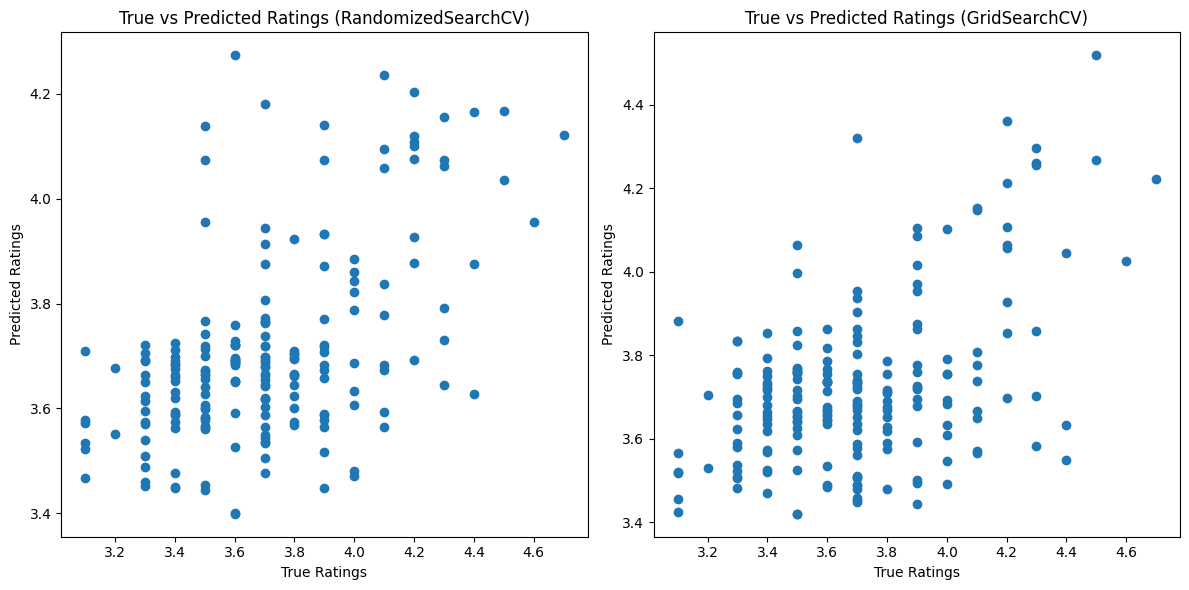

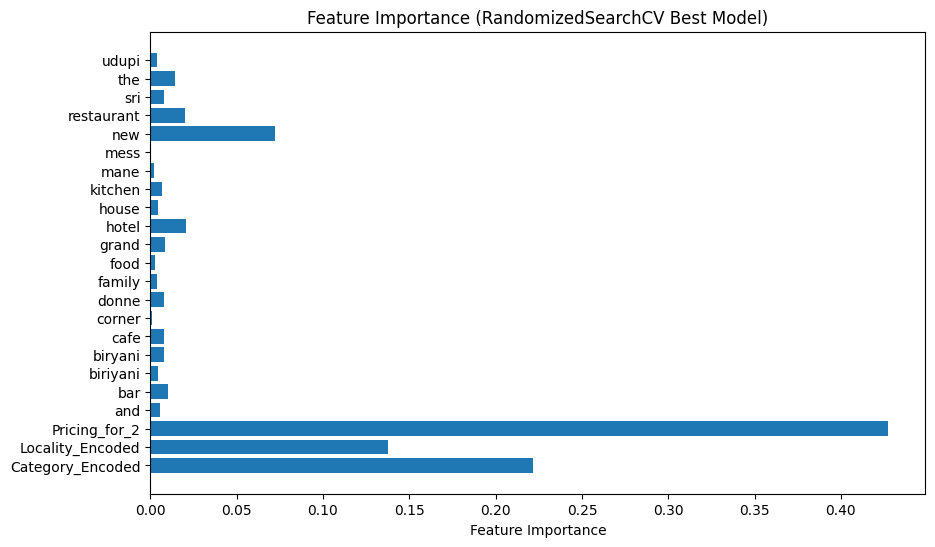

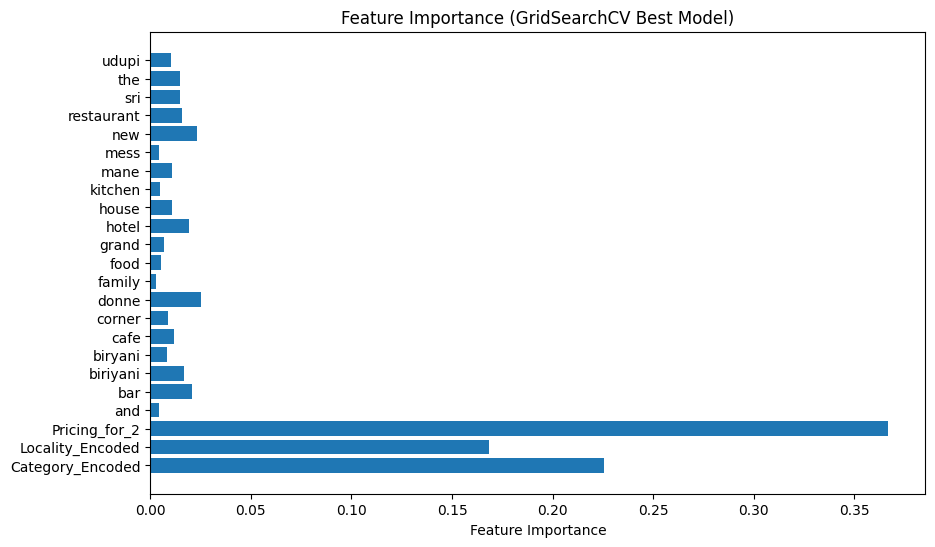

Comparison of Models:
                Model       MSE  R-squared       MAE
0  RandomizedSearchCV  0.072374   0.290196  0.215387
1        GridSearchCV  0.080247   0.212985  0.229901
Full Model Mean Squared Error: 0.014620751517552023
Full Model R-squared: 0.8694331503841273
Full Model Mean Absolute Error: 0.09484969934871945
Models saved successfully!


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load the Bangalore dataset
url_bangalore = '/content/Bangalore_Restaurants (1).csv'  # Provide the correct path to your Bangalore dataset
df_bangalore = pd.read_csv(url_bangalore)

# Load the Pune dataset
url_pune = '/content/Pune Restaurants.csv'  # Provide the correct path to your Pune dataset
df_pune = pd.read_csv(url_pune)

# Preprocessing function for both datasets
def preprocess(df):
    # Make a copy of the dataframe to avoid 'SettingWithCopyWarning'
    df = df.copy()

    # Handle missing values
    df = df.dropna(subset=['Dining_Rating', 'Category', 'Pricing_for_2', 'Locality'])

    # Encode categorical variables
    le_category = LabelEncoder()
    df['Category_Encoded'] = le_category.fit_transform(df['Category'])  # Assign to the full dataframe

    le_locality = LabelEncoder()
    df['Locality_Encoded'] = le_locality.fit_transform(df['Locality'])  # Assign to the full dataframe

    # Convert Pricing_for_2 into numerical values
    df['Pricing_for_2'] = df['Pricing_for_2'].apply(
        lambda x: np.mean([int(i) for i in x.replace('₹', '').split(' - ') if i.isdigit()])
        if isinstance(x, str) else x
    )  # Directly modify the dataframe

    # Text Preprocessing for Restaurant Name
    tfidf = TfidfVectorizer(max_features=20)
    restaurant_name_tfidf = tfidf.fit_transform(df['Restaurant_Name']).toarray()
    restaurant_name_df = pd.DataFrame(restaurant_name_tfidf, columns=tfidf.get_feature_names_out())

    # Concatenate the original DataFrame with the new features
    df = pd.concat([df, restaurant_name_df], axis=1)

    return df

# Apply preprocessing to both datasets
df_bangalore = preprocess(df_bangalore)
df_pune = preprocess(df_pune)

# Combine both datasets (Bangalore + Pune)
df_combined = pd.concat([df_bangalore, df_pune], ignore_index=True)

# Remove rows with missing target variable 'Dining_Rating'
df_combined = df_combined.dropna(subset=['Dining_Rating'])

# Selecting features and target variable for combined dataset
X_combined = df_combined[['Category_Encoded', 'Locality_Encoded', 'Pricing_for_2'] + list(df_bangalore.columns[-20:])]
y_combined = df_combined['Dining_Rating']

# Split the combined dataset into training and testing sets
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Model Training with Random Forest Regressor and Cross-Validation
model_combined = RandomForestRegressor(n_estimators=100, random_state=42)
model_combined.fit(X_train_combined, y_train_combined)

# Make predictions
y_pred_combined = model_combined.predict(X_test_combined)

# Evaluate the model with multiple metrics
mse_combined = mean_squared_error(y_test_combined, y_pred_combined)
r2_combined = r2_score(y_test_combined, y_pred_combined)
mae_combined = mean_absolute_error(y_test_combined, y_pred_combined)

print(f'Mean Squared Error: {mse_combined}')
print(f'R-squared: {r2_combined}')
print(f'Mean Absolute Error: {mae_combined}')

# Visualize the results (True vs Predicted Ratings)
plt.scatter(y_test_combined, y_pred_combined)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs Predicted Dining Ratings (Combined Bangalore and Pune)')
plt.show()

# Feature importance visualization
feature_importances_combined = model_combined.feature_importances_
features_combined = X_combined.columns
plt.barh(features_combined, feature_importances_combined)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Predicting Dining Rating (Combined Dataset)')
plt.show()

cv_scores = cross_val_score(model_combined, X_combined, y_combined, cv=3, scoring='neg_mean_squared_error')
print(f'Cross-Validation MSE Scores: {cv_scores}')
print(f'Mean CV MSE: {np.mean(cv_scores)}')

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(estimator=model_combined, param_distributions=param_grid,
                                   n_iter=10, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
random_search.fit(X_train_combined, y_train_combined)

print(f'Best parameters from RandomizedSearchCV: {random_search.best_params_}')

# For GridSearchCV
grid_search = GridSearchCV(estimator=model_combined, param_grid=param_grid, cv=3,
                           scoring='neg_mean_squared_error', n_jobs=-1)

# Use a smaller random sample (e.g., 10% of the dataset)
df_combined_sample = df_combined.sample(frac=0.1, random_state=42)

X_combined_sample = df_combined_sample[['Category_Encoded', 'Locality_Encoded', 'Pricing_for_2'] + list(df_bangalore.columns[-20:])]
y_combined_sample = df_combined_sample['Dining_Rating']

# Re-split, retrain, and re-evaluate using the smaller sample
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined_sample, y_combined_sample, test_size=0.2, random_state=42)

# Evaluate the best RandomizedSearchCV model
best_random_search_model = random_search.best_estimator_

# Predictions with the best RandomizedSearchCV model
y_pred_random_search = best_random_search_model.predict(X_test_combined)

# Evaluate the best RandomizedSearchCV model
mse_random_search = mean_squared_error(y_test_combined, y_pred_random_search)
r2_random_search = r2_score(y_test_combined, y_pred_random_search)
mae_random_search = mean_absolute_error(y_test_combined, y_pred_random_search)

print(f'RandomizedSearchCV Best Model Mean Squared Error: {mse_random_search}')
print(f'RandomizedSearchCV Best Model R-squared: {r2_random_search}')
print(f'RandomizedSearchCV Best Model Mean Absolute Error: {mae_random_search}')

# Evaluate the best GridSearchCV model
grid_search.fit(X_train_combined, y_train_combined)

best_grid_search_model = grid_search.best_estimator_

# Predictions with the best GridSearchCV model
y_pred_grid_search = best_grid_search_model.predict(X_test_combined)

# Evaluate the best GridSearchCV model
mse_grid_search = mean_squared_error(y_test_combined, y_pred_grid_search)
r2_grid_search = r2_score(y_test_combined, y_pred_grid_search)
mae_grid_search = mean_absolute_error(y_test_combined, y_pred_grid_search)

print(f'GridSearchCV Best Model Mean Squared Error: {mse_grid_search}')
print(f'GridSearchCV Best Model R-squared: {r2_grid_search}')
print(f'GridSearchCV Best Model Mean Absolute Error: {mae_grid_search}')

# Visualize the results (True vs Predicted Ratings) for both models
plt.figure(figsize=(12, 6))

# True vs Predicted for RandomizedSearchCV
plt.subplot(1, 2, 1)
plt.scatter(y_test_combined, y_pred_random_search)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs Predicted Ratings (RandomizedSearchCV)')

# True vs Predicted for GridSearchCV
plt.subplot(1, 2, 2)
plt.scatter(y_test_combined, y_pred_grid_search)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs Predicted Ratings (GridSearchCV)')

plt.tight_layout()
plt.show()

# Feature importance visualization for the best models
# For RandomizedSearchCV best model
feature_importances_random_search = best_random_search_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X_combined.columns, feature_importances_random_search)
plt.xlabel('Feature Importance')
plt.title('Feature Importance (RandomizedSearchCV Best Model)')
plt.show()

# For GridSearchCV best model
feature_importances_grid_search = best_grid_search_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X_combined.columns, feature_importances_grid_search)
plt.xlabel('Feature Importance')
plt.title('Feature Importance (GridSearchCV Best Model)')
plt.show()

# Compare RandomizedSearchCV vs GridSearchCV results
results_comparison = pd.DataFrame({
    'Model': ['RandomizedSearchCV', 'GridSearchCV'],
    'MSE': [mse_random_search, mse_grid_search],
    'R-squared': [r2_random_search, r2_grid_search],
    'MAE': [mae_random_search, mae_grid_search]
})

print("Comparison of Models:")
print(results_comparison)

# Model evaluation on the full dataset (if needed)
full_model_combined = RandomForestRegressor(n_estimators=100, random_state=42)
full_model_combined.fit(X_combined, y_combined)

# Predict on full dataset
y_pred_full = full_model_combined.predict(X_combined)

# Evaluate the full model
mse_full = mean_squared_error(y_combined, y_pred_full)
r2_full = r2_score(y_combined, y_pred_full)
mae_full = mean_absolute_error(y_combined, y_pred_full)

print(f'Full Model Mean Squared Error: {mse_full}')
print(f'Full Model R-squared: {r2_full}')
print(f'Full Model Mean Absolute Error: {mae_full}')

# Save models if needed for future use
import joblib

# Saving the best models
joblib.dump(best_random_search_model, '/content/random_search_best_model.pkl')
joblib.dump(best_grid_search_model, '/content/grid_search_best_model.pkl')
joblib.dump(full_model_combined, '/content/full_model_combined.pkl')

print("Models saved successfully!")

